<a href="https://colab.research.google.com/github/ArthurCTLin/Workbook/blob/main/ML_Course/HW1/COVID_19_Cases_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 1 from [***Machine Learning***](https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.html)
* **Professor :** Hung-Yi, Lee
* **Objectives :**
  * Solve a regression problem with deep neural networks (DNN).
  * Understand basic DNN training tips.
  * Get familiar with PyTorch.
* [**Referenced Code**](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=mz0_QVkxCrX3) provided by course TA Heng-Jui Chang


### **Download Data**
If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

The method to download dataset from kaggle to Colab can reference this link: https://www.kaggle.com/general/74235

In [232]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 45.3MB/s]


### **Import Packages**

In [233]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Make the results of every experiments are reproducible : https://www.itread01.com/content/1550034200.html
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False # https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### **Utilities**
* Device
* Plotting

In [234]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

### **Preprocess**

* Information of Data
* Preprocess
  * Feature Extraction
  * Construct `COVID19Dataset` class
  * DataLoader

#### Information of Data
The dataset contains the 3 days information.
* **40** states encoded to one-hot vectors
  * e.g. AL, AK, AZ...
* **4 X 3** COVID-like illness
  * e.g. cli, ili, hh_cmnty_cli, nohh_cmnty_cli
  * Including 3 days information
* **8 X 3** Behavior Indicators
  * e.g. wearing_mask, travel_outside_state, ...
  * Including 3 days information
* **5 X 3** Mental Health Indicators
  * e.g. anxious, depressed, ...
  * Including 3 days information
* **1 X (2or3)** Tested Positive Cases
  * tested_positive (this is what we want to predict)
  * Training data includes 3 days information
  * Testing data includes the first 2 days information and the 3rd day is for prediction.

Therefore, the number of information/columns are :
* Training data : 
  * 95 columns (above items + id)
  * Info: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
* Testing data : 
  * 94 columns (above items + id)
  * Info: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))

In [235]:
train_dat = pd.read_csv("./covid.train.csv")
train_dat.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,...,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.000647,53.439316,43.279629,19.586492,0.838995,0.807766,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607,0.883833,0.893020,26.480624,21.003983,84.049437,12.224644,35.380198,60.664482,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [236]:
test_dat = pd.read_csv("./covid.train.csv")
test_dat.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,...,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.000647,53.439316,43.279629,19.586492,0.838995,0.807766,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607,0.883833,0.893020,26.480624,21.003983,84.049437,12.224644,35.380198,60.664482,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [237]:
with open("./covid.train.csv", "r") as fp:
  data = list(csv.reader(fp))
  #print(data)
  data = np.array(data[1:])[:, 1:]
  print(data)

[['1.0' '0.0' '0.0' ... '53.9915494' '43.6042293' '20.7049346']
 ['1.0' '0.0' '0.0' ... '54.185521' '42.6657659' '21.2929114']
 ['1.0' '0.0' '0.0' ... '53.6370693' '42.972417' '21.1666563']
 ...
 ['0.0' '0.0' '0.0' ... '67.731162' '38.740651' '12.6134414']
 ['0.0' '0.0' '0.0' ... '67.7950996' '38.595125' '12.4772268']
 ['0.0' '0.0' '0.0' ... '68.2840782' '38.4538196' '11.8117187']]


In [238]:
with open("./covid.train.csv", "r") as fp:
  data = list(csv.reader(fp))
  #print(data)
  data = np.array(data[1:])[:, 1:].astype(float)
  print(data)

[[ 1.         0.         0.        ... 53.9915494 43.6042293 20.7049346]
 [ 1.         0.         0.        ... 54.185521  42.6657659 21.2929114]
 [ 1.         0.         0.        ... 53.6370693 42.972417  21.1666563]
 ...
 [ 0.         0.         0.        ... 67.731162  38.740651  12.6134414]
 [ 0.         0.         0.        ... 67.7950996 38.595125  12.4772268]
 [ 0.         0.         0.        ... 68.2840782 38.4538196 11.8117187]]


#### **Feature Extraction**
* Normalization data (Z-score, Min-max scaling, L2...)
* Select Best feature set with SelectKBest in sklearn
  
  

In [239]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

train_set = pd.read_csv('./covid.train.csv')
x = train_set[train_set.columns[1:94]]
y = train_set[train_set.columns[94]]

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# The normalization method
norm = MinMaxScaler() # Min-max scaling (Can be tuned)
train_set_norm = pd.DataFrame(norm.fit_transform(x), columns=x.keys()) 

bestfeats = SelectKBest(score_func=f_regression)
fit = bestfeats.fit(train_set_norm, y)
dfcolumns = pd.DataFrame(train_set_norm.columns)
dfscores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.sort_values('Score', ascending = False, inplace = True) 
feats_id = list(featureScores.head(14).index)
print(feats_id)
featureScores.head(25)

[75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]


,Specs,Score
75,tested_positive.1,148069.658278
57,tested_positive,69603.872591
42,hh_cmnty_cli,9235.492094
60,hh_cmnty_cli.1,9209.019558
78,hh_cmnty_cli.2,9097.375172
43,nohh_cmnty_cli,8395.421300
61,nohh_cmnty_cli.1,8343.255927
79,nohh_cmnty_cli.2,8208.176435
40,cli,6388.906849
58,cli.1,6374.548000


#### **Contruct Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features


In [240]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        # Read data into numpy arrays, take off 'title' & 'id' and convert the value from str into float
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # Whether to select the specific features or not
        if not target_only:     
            feats = list(range(93))
        else:
            feats = feats_id

        if mode == 'test':
            # Testing data
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

#### **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [241]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
              dataset, 
              batch_size,
              shuffle=(mode == 'train'), 
              drop_last=False,
              num_workers=n_jobs, 
              pin_memory=True
            )
    return dataloader

### **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

In [242]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.1),
            nn.LeakyReLU(0.3),
            nn.Linear(32, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        regularization_loss = 0
        for param in model.parameters():
         # regularization_loss += torch.sum(abs(param)) # L1
          regularization_loss += torch.sum(param ** 2) # L2
        return self.criterion(pred, target) +  0.0008 * regularization_loss

### **Training/Validation/Testing**

#### **Training**

In [243]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                   # set model to training mode
        for x, y in tr_set:              # iterate through the dataloader
            optimizer.zero_grad()           # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)             # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)   # compute loss
            mse_loss.backward()            # compute gradient (backpropagation)
            optimizer.step()             # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

#### **Validation**

In [244]:
def dev(dv_set, model, device):
    model.eval()                            # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                       # iterate through the dataloader
        x, y = x.to(device), y.to(device)            # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
          pred = model(x)                    # forward pass (compute output)
          mse_loss = model.cal_loss(pred, y)          # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)          # compute averaged loss

    return total_loss

#### **Testing**

In [245]:
def test(tt_set, model, device):
    model.eval()                     # set model to evalutation mode
    preds = []
    for x in tt_set:                  # iterate through the dataloader
        x = x.to(device)              # move data to device (cpu/cuda)
        with torch.no_grad():            # disable gradient calculation
            pred = model(x)           # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()      # concatenate all predictions and convert to a numpy array
    return preds

### **Hyper-parameters**
`config` contains hyper-parameters for training and the path to save the model.

In [246]:
device = get_device()         
os.makedirs('models', exist_ok=True)
target_only = True          

config = {
    'n_epochs': 10000,
    'batch_size': 64,
    'optimizer': 'Adam',
    'optim_hparas': {
     #   'lr': 0.001,
     #   'momentum': 0.9
     # 'weight_decay' : 0.0008              
    },
    'early_stop': 500,        # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'
}

### **Implementation**

#### **Load data and model**

In [247]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [248]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

#### **Start Training**

In [249]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 271.8622)
Saving model (epoch =    2, loss = 269.3505)
Saving model (epoch =    3, loss = 235.2188)
Saving model (epoch =    4, loss = 215.9661)
Saving model (epoch =    5, loss = 179.8055)
Saving model (epoch =    6, loss = 160.7666)
Saving model (epoch =    7, loss = 114.2547)
Saving model (epoch =    8, loss = 93.1479)
Saving model (epoch =   10, loss = 92.4693)
Saving model (epoch =   11, loss = 28.8423)
Saving model (epoch =   13, loss = 24.6544)
Saving model (epoch =   14, loss = 10.4347)
Saving model (epoch =   16, loss = 8.8821)
Saving model (epoch =   20, loss = 8.4435)
Saving model (epoch =   21, loss = 8.4268)
Saving model (epoch =   22, loss = 7.6194)
Saving model (epoch =   23, loss = 7.2473)
Saving model (epoch =   27, loss = 6.2719)
Saving model (epoch =   30, loss = 5.4156)
Saving model (epoch =   31, loss = 5.4129)
Saving model (epoch =   34, loss = 5.3164)
Saving model (epoch =   36, loss = 4.7017)
Saving model (epoch =   40, loss = 

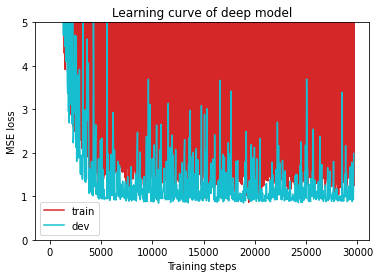

In [250]:
plot_learning_curve(model_loss_record, title='deep model')

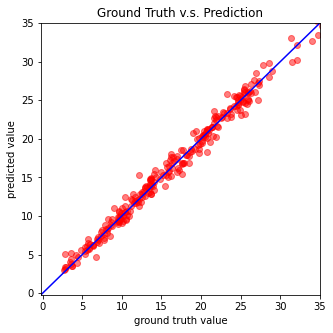

In [251]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

#### **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [252]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


## Reference
* Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
* Optimization techniques : https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/small-gradient-v7.pdf
* Normalization & Regularization : https://ithelp.ithome.com.tw/articles/10201722